In [1]:
import pandas as pd
import json
import glob

In [168]:
# using only biorxiv_medrxiv for POC, write data from csv
fl = glob.glob("../data/biorxiv_medrxiv/biorxiv_medrxiv/*.json")

def get_data_v1(fl):
    aggregator = []
    for each in fl:
        with open(each, "r") as fr:
            data = json.load(fr)
            paper_id = data.get("paper_id")
            title = data.get("metadata").get("title")
            abstract = ''.join([x.get("text") for x in data.get("abstract")])
            # abstract paragraphs may not be in order, ignoring that fact.
            aggregator.append({"paper_id":paper_id, "title":title, "abstract":abstract})
    return pd.DataFrame(aggregator)
df = get_data_v1(fl)
df.to_csv("data.csv", index=False)

In [173]:
# read csv for colab
df = pd.read_csv("data.csv")

In [175]:
df.sample(10)

,abstract,paper_id,title
581,The novel coronavirus disease 2019 (COVID-19) ...,54ae20515fcef8417e255b19df1a5bf6f2ab40bb,Title: Modelling the coronavirus disease (COVI...
522,Objective: We aim to summarize reliable eviden...,9bf1677e5f822110e736076a4ba6960a80f2f348,Clinical characteristics of 50466 patients wit...
320,Coronavirus disease-2019 (COVID-19) is a rapid...,f19e2df932f90f387fe71533f3802875d9042160,Lymphopenia predicts disease severity of COVID...
388,This study builds a SEIRD model that considers...,f24d3b4b4af138be06b7452b7acefc8948bc1056,Beware of asymptomatic transmission: Study on ...
460,"Viruses evolve extremely quickly, so reliable ...",b9dbb79c9e06164c3b7fefce67c11c5d6caf1fcd,Interpretable detection of novel human viruses...
675,The epidemic caused by the novel coronavirus i...,537009c0181c3269f40753f75ddca4d17ae8abae,Estimating the cure rate and case fatality rat...
829,Knowledge of the host factors required for nor...,ed0a318f34fe2d65cce6127be009ad7d5f3c7cae,Noroviruses subvert the core stress granule co...
972,Cases from the ongoing outbreak of atypical pn...,158e546658e42ab0a89d174bc9facb437a034df6,NaN
744,Lectins are glycan-binding proteins with no ca...,fa6c14304fc37470639d55f97f7903035d768bd2,Pseudomonas aeruginosa lectin LecB impairs ker...
772,"Currently, COVID-19 caused by severe acute res...",6ede7d40a9858d89341de780a3be9e8b43291151,SARS-CoV-2 invades host cells via a novel rout...


In [5]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [6]:
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [7]:
# Write embeddings to file
EMBEDDING_DIM=100
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)

'/Users/sagarkar/PycharmProjects/corona/glove.6B.100d.txt'

In [8]:
word2vec_output_file = '{0}.word2vec'.format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

(400000, 100)

In [9]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


In [126]:
glove.get_vector("medicine")

array([ 0.33396  ,  0.33144  , -0.13395  ,  0.14739  ,  0.3178   ,
       -0.02545  ,  0.88513  , -0.12636  , -0.42275  , -0.10626  ,
       -0.61972  , -0.70793  ,  0.40188  ,  1.4851   ,  0.077743 ,
       -0.37474  ,  0.6901   ,  0.0087892, -0.64876  , -0.45819  ,
       -0.43245  , -0.062628 , -0.087284 , -0.078459 , -0.38527  ,
        0.79442  ,  0.31637  , -1.3598   , -0.5347   , -0.14641  ,
       -0.67635  ,  0.092534 , -0.79324  ,  0.11669  , -1.2946   ,
        0.1994   , -1.0341   ,  0.84662  , -0.72092  , -0.32747  ,
       -0.53897  ,  0.14541  , -0.6759   , -1.6845   , -0.043898 ,
        0.054386 , -0.03124  ,  0.54537  , -0.61069  , -0.017709 ,
        0.68863  ,  0.25688  ,  0.19198  ,  0.049682 ,  0.092322 ,
       -1.2278   ,  0.0031416, -0.66347  ,  1.4236   , -0.14759  ,
        0.73668  ,  0.22449  ,  0.24277  , -0.066424 ,  0.14237  ,
        0.19105  ,  0.054326 , -0.095632 ,  0.53485  ,  0.049847 ,
       -0.30469  , -0.03444  , -0.12034  ,  1.0387   , -0.2633

In [127]:
from tensorflow.keras.preprocessing.text import Tokenizer
df = df.drop(df[(df.title=="") | (df.abstract=="")].index).reset_index(drop=True)
X = df.title.values
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True
CHAR_LEVEL = False
X_tokenizer = Tokenizer(
    filters=FILTERS, lower=LOWER, char_level=CHAR_LEVEL, oov_token='<UNK>')
X_tokenizer.fit_on_texts(X)
X_processed = np.array(X_tokenizer.texts_to_sequences(X))
df["title_P"] = X_tokenizer.sequences_to_texts(X_processed)

In [128]:
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform

def vectorize_sents(sents, g_em):
    ret_sents = []
    for each in sents:
        ret_sents.append(vectorize_sent(each, g_em))
    return ret_sents

def vectorize_sent(sent, g_em):
    sent_vec = np.zeros(EMBEDDING_DIM)
    numw = 0
    for w in sent:
        try:
            sent_vec = np.add(sent_vec, g_em.get_vector(w))
            numw+=1
        except:
            pass
    return sent_vec / np.sqrt(sent_vec.dot(sent_vec))

In [129]:
df["title_v"] = vectorize_sents(df["title_P"], glove)

In [165]:
def get_most_similar(query_title):
    print(f"Query Title: {query_title}")
    vp = np.array(X_tokenizer.texts_to_sequences([query_title]))
    vp_ = X_tokenizer.sequences_to_texts(vp)
    print(f"processed Query Title: {vp_}")
    v0 = vectorize_sent(vp_[0], glove)
    print(f"Vector representation: {v0}")
    idx = cdist([v0], np.stack( df["title_v"].values, axis=0 ), metric='cosine')[0].argsort()[:5]
    top_5 = df.title.loc[idx].values
    print(f"Top 5 Similar titles: {top_5}")

In [166]:
get_most_similar('Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19) Infection: Inference Using Exported Cases')

Query Title: Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19) Infection: Inference Using Exported Cases
processed Query Title: ['real time estimation of the risk of death from novel coronavirus covid 19 infection inference using exported cases']
Vector representation: [-0.08944049  0.08030243  0.03130218 -0.03837023 -0.09138199  0.03745923
  0.05690668  0.04280562 -0.09157383  0.03873019  0.1567052  -0.11328872
 -0.10518623  0.09219331 -0.00064739 -0.06460973 -0.01128977  0.01706874
 -0.01479797  0.05254806  0.12806162  0.0226967   0.01432267  0.09346716
  0.03521839  0.13651125  0.06377857  0.01071611  0.06011562 -0.0583953
  0.0837486   0.16305072  0.0201432   0.06262094  0.0885884   0.04253153
  0.09828649  0.04840956  0.06125467  0.06451439  0.05303501 -0.11661939
 -0.01133797 -0.13897086 -0.03313486  0.03739668 -0.14473379 -0.00374619
  0.03193703 -0.07896253  0.0206585   0.03899542  0.09099418  0.00204729
 -0.13599264 -0.42545587 -0.02376047  0.06890221

In [132]:
df.head()

,abstract,paper_id,title,title_P,title_v
0,New anti-AIDS treatments must be continually d...,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,Multimerization of HIV-1 integrase hinges on c...,multimerization of hiv 1 integrase hinges on c...,"[-0.08428442041133981, 0.08764245487167917, 0...."
1,Rationale: Several studies have estimated basi...,abcfffafab399149d4adadd6bb458c4994e2025d,Time-varying transmission dynamics of Novel Co...,time varying transmission dynamics of novel co...,"[-0.08048400960892867, 0.0837210941022766, 0.0..."
2,Summary Statement: DUX4 is thought to mediate ...,0cb9c296684ca5e71462d825cab2827854a01544,p53 is not necessary for DUX4 pathology,p53 is not necessary for dux4 pathology,"[-0.08063293655889561, 0.08293353992491624, 0...."
3,"emerged in late 2019 1,2 . Initial outbreaks i...",9bbfd3d34ee18ea1b9f4669331a6cee9c5992893,Virological assessment of hospitalized cases o...,virological assessment of hospitalized cases o...,"[-0.07290673353974543, 0.0911513279907879, 0.0..."
4,A novel coronavirus (SARS-CoV-2) first detecte...,1218f278a4f8d83dac14b23c8f698062812ef9d5,Potential impact of seasonal forcing on a SARS...,potential impact of seasonal forcing on a sars...,"[-0.08420929942660703, 0.09190924287475682, 0...."


In [134]:
distances = pdist(np.stack( df["title_v"].sample(30).values, axis=0 ), metric='cosine')
dist_matrix = squareform(distances)

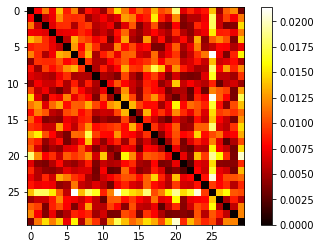

In [135]:
# cosine distance, not similarity
plt.imshow(dist_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()